# Homogeneous Field Correction

This section explains how Homogeneous Field Correction (HFC) is used to attenuate artefacts in the OPM  data. Homogeneous Field Correction (HFC) is a preprocessing technique that suppresses artefacts that manifest as spatially uniform magnetic fields across the sensor array. These artefacts are generated by sources in the environment that may come from electrical devices or moving magnetic objects. Examples are ventilation systems, belt buckles on the participant, elevators, driving cars, magnetic door latches, as well as vibrations. Another large contribution comes from movements in which the sensor array is moving within the recidual fields of the magnetically shielded room. These artefacts tend to generate magnetic fields that are fairly spatially homogenous as they are typically far away from the sensor array. Brain activity, on the other hand, produces magnetic fields which are less homogenous with higher spatial gradients as the fields are generated by neuronal sources with proximity to the sensors. 
HFC works by attenuating the spatially homogenous components of the magnetic fields, thus allowing for better detection of the magnetic fields generated by the brain.
This section explains how Homogeneous Field Correction (HFC) is used to clean OPM data. 

HFC operates by applying a linear projection to all the sensors. If there are sensors that are 'flat' or reflect excessive noise, they must be removed prior to the HFC procedure such that they do not contribute to spreading noise. Therefore, prior to applying HFC, it is important to identify and exclude 'bad' sensors. 


## Import the necessary modules
Below are the required Python modules to be imported for this section

In [1]:
import mne
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import array
from pprint import pprint
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events

## File overview

The chapter relies on the file (embedded in BIDS):
```
< BIDS_ROOT >/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```
and generates the output file in the 'derivatives' folder of the BIDS 
```
<BIDS_ROOT>/derivatives/preprocessing/sub-01/ses-01meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif
```




## Loading the BIDS data

Specify the parameters allowing for defining the BIDS folder `data_path` which is dependent on where the data are stored locally.  

In [2]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'eve'
events_extension = '.tsv'

# data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=meg_suffix, extension=meg_extension, root=bids_root)

Create a 'derivative folder' where the processed data will be stored:

In [3]:
deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=meg_suffix, root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'hfc_raw') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)

Read the raw data

In [4]:
raw = read_raw_bids(bids_path=bids_path, verbose=False,extra_params={'preload':True})

## Idenfity the Faulty Sensors

The first step is to flag sensors as “bad” based on what we observed during acquisition. After the bad‐sensor list is further augmented by identifying outliers based on the power spectral density estimates. The sensors B4 and H6 happened to be faulty. 

In [6]:
ch_names = raw.info['ch_names']
bad_chs = ['B4', 'H6']
bad_channels = [name for name in ch_names if any(ch in name for ch in bad_chs)]
raw.info['bads'] = bad_channels
raw.save
# Print the bad channels 
print("Bad channels marked:", raw.info['bads'])

Bad channels marked: ['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']


Now, additional noisy bad sensors will be identified based on the average power spectral density (PSD) of each sensor. Sensors with an average PSD value crossing a predefined threshold will be flagged as bad and hence  not contribute towards the HFC filtering. 

## Calculate and plot the PSDs

The sensor power will be considered separately for X, Y and Z axes. The seperation in sensors is mainly done to facility the later interpretation of the data. The Z axis correspond to magnetometers being most sensitive to field perpendicular to the brain surface. The respective sets of sensors will be selected based on their labels: 

In [7]:
OPMX = [item for item in raw.ch_names if item.endswith("X")]
OPMY = [item for item in raw.ch_names if item.endswith("Y")]
OPMZ = [item for item in raw.ch_names if item.endswith("Z") and not item.startswith("BNC")]

Compute PSD for each X,Y and Z directions. This will be done using a time window of 1500 points resulting in a 0.5 Hz spectral resolution.

In [8]:
n_fft = 1500
raw_PSDX = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMX, n_fft=n_fft, n_overlap=int(n_fft/2))
raw_PSDY = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMY, n_fft=n_fft, n_overlap=int(n_fft/2))
raw_PSDZ = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMZ, n_fft=n_fft, n_overlap=int(n_fft/2))


psdsX = raw_PSDX.get_data() # units are in T^2/Hz
freqsX = raw_PSDX.freqs 
psd_dbX = 10 * np.log10(psdsX * 1e30)  # Ref power: 1fT^2=1e-30T^2           
average_powerX = np.mean(psd_dbX, axis=1)

psdsY = raw_PSDY.get_data() # units are in T^2/Hz
freqsY = raw_PSDY.freqs 
psd_dbY = 10 * np.log10(psdsY * 1e30)  # Ref power: 1fT^2=1e-30T^2           
average_powerY = np.mean(psd_dbY, axis=1)

psdsZ = raw_PSDZ.get_data() # units are in T^2/Hz
freqsZ = raw_PSDZ.freqs 
psd_dbZ = 10 * np.log10(psdsZ * 1e30)  # Ref power: 1fT^2=1e-30T^2           
average_powerZ = np.mean(psd_dbZ, axis=1)

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


To plot the result using the commands 

Text(0.5, 1.0, 'axis Z')

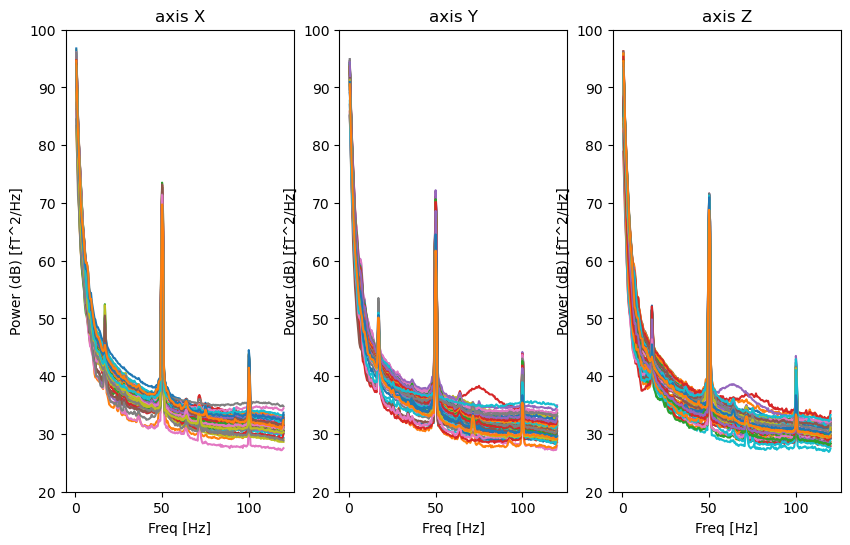

In [9]:
plt.figure(figsize=(10, 6))

plt.subplot(1,3,1)
plt.plot(freqsX,psd_dbX.T);plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power (dB) [fT^2/Hz]');plt.title('axis X')

plt.subplot(1,3,2)
plt.plot(freqsY,psd_dbY.T);plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power (dB) [fT^2/Hz]');plt.title('axis Y')

plt.subplot(1,3,3)
plt.plot(freqsY,psd_dbZ.T);plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power (dB) [fT^2/Hz]');plt.title('axis Z')

As can be overserved, the spectra looks reasonable and there are no obvious outliers in the 0 to 50 Hz range. 

### Histograms of sensor power

As a next step, histograms of the power averaged across freqeuncues will be plotted for the different sensors.

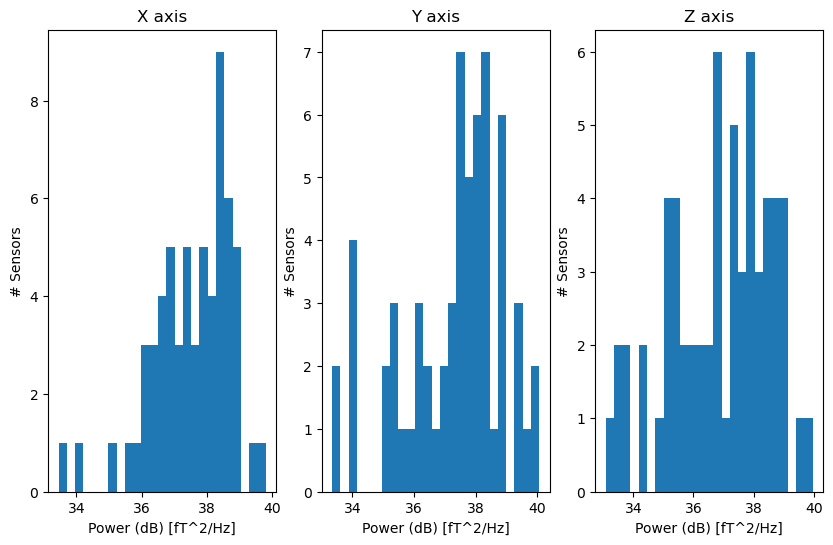

In [10]:
plt.figure(figsize=(10, 6))
BNS = 25
plt.subplot(1,3,1)
plt.hist(average_powerX, bins=BNS); plt.xlabel('Power (dB) [fT^2/Hz]');plt.ylabel('# Sensors'); plt.title('X axis');
plt.subplot(1,3,2)
plt.hist(average_powerY, bins=BNS); plt.xlabel('Power (dB) [fT^2/Hz]');plt.ylabel('# Sensors'); plt.title('Y axis');
plt.subplot(1,3,3)
plt.hist(average_powerZ, bins=BNS); plt.xlabel('Power (dB) [fT^2/Hz]');plt.ylabel('# Sensors'); plt.title('Z axis');

While the power distributions look reasonable, as the sensors all were in an excellent state when doing the data collection. we will here reject sensors with a noise level above 39.5 db. This is admittedly a bit arbitrary but the point is to provide an example of automatic thresholding. 

### Identifying and flagging sensors with high power

To identify the sensors above the threshold of 39.5 dB write

In [11]:
## X Direction
OPMXbad = [OPMX[i] for i, avg in enumerate(average_powerX) if avg > 39.5]
print(OPMXbad)

## Y Direction
OPMYbad = [OPMY[i] for i, avg in enumerate(average_powerY) if avg > 39.5]
print(OPMYbad)

## Z Direction
OPMZbad = [OPMZ[i] for i, avg in enumerate(average_powerZ) if avg > 39.5]
print(OPMZbad)

['O9 G3 X']
['T5 C5 Y', 'T11 G7 Y', 'O2 H3 Y']
['T1 C7 Z', 'T5 C5 Z']


Flag the sensors above the threshold as bad with the data structure. This will be done by augmenting the existing list of bad sensors

In [12]:
new_bads = OPMXbad + OPMYbad + OPMZbad
raw.info['bads'].extend(new_bads)
print(raw.info['bads'])

['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X', 'O9 G3 X', 'T5 C5 Y', 'T11 G7 Y', 'O2 H3 Y', 'T1 C7 Z', 'T5 C5 Z']


**Question 1:** Where are the noisy sensors located? Identify and mark the sensor on the layout below:

**Question 2:** Plot the time course of a few noisy sensors and compare to non-noisy sensors. What characterizes the noisy sensors?

## Apply Homogenous Field Correction

Before doing HFC plot the PSD excluding the bad sensors. 

#### Plot of the raw data before pre-processing

For brevity, we will plot data from a subset of sensors, selecting every 5th sensor.

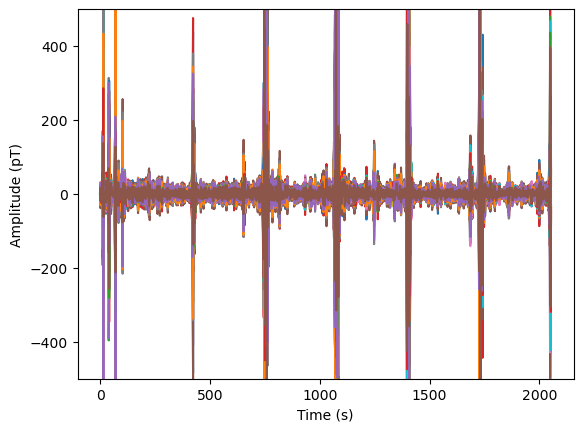

In [13]:
picks = mne.pick_types(raw.info, meg=True,exclude='bads')

amp_scale = 1e12  # Converting to pico Tesla(pT)
stop = len(raw.times) - 300
step = 500
data_ds, time_ds = raw[picks[::5], :stop]
data_ds, time_ds = data_ds[:, ::step]* amp_scale , time_ds[::step]

plt.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1));
plt.ylim(-500, 500)
plt.xlabel('Time (s)'); 
plt.ylabel('Amplitude (pT)')
plt.xlim=time_ds[[0, -1]];

Note the large artefacts every ~300 s. They occur at the breaks between the blocks and are probably due to head movements as the partipant is stretching and repositioning. 

### Interference rejection using Homogeneous Field Correction

In [14]:
rawHFC=raw.copy()
projs = mne.preprocessing.compute_proj_hfc(rawHFC.info, order=2)
rawHFC.add_proj(projs).apply_proj(verbose="error")

8 projection items deactivated


<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 219 x 1539808 (2053.1 s), ~2.52 GiB, data loaded>

Plotting the raw data after applying HFC

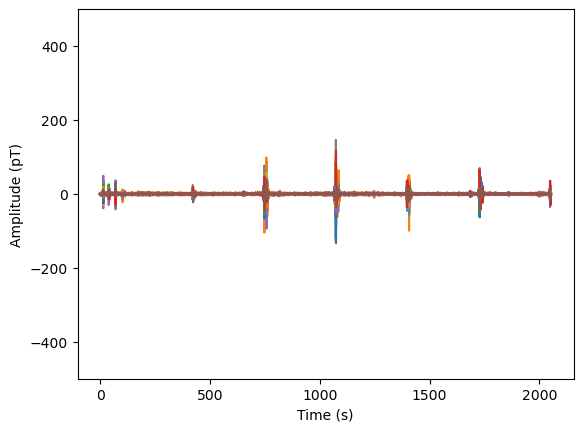

In [16]:
picks = mne.pick_types(rawHFC.info, meg=True,exclude='bads')

amp_scale = 1e12  # Converting to pico Tesla(pT)
stop = len(raw.times) - 300
step = 500
data_ds, time_ds = rawHFC[picks[::5], :stop]
data_ds, time_ds = data_ds[:, ::step]* amp_scale , time_ds[::step]

plt.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1));
plt.ylim(-500, 500);
plt.xlabel('Time (s)'); 
plt.ylabel('Amplitude (pT)')
plt.xlim=time_ds[[0, -1]];
plt.show()

The artifacts are now clearly reduced showing the utility of the HFC. These artifacts prior to the HFC were likely due to the participant moving within room. Despite the shielding, there will be recidual field remaining that procudes a signal when the sensors are moving within the recidual field. 

### Powerspectra after HFC

Another way to inspect the effects of HFC is to consider the power-spectra

In [18]:
n_fft = 1500
raw_PSDZ = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMX, n_fft=n_fft, n_overlap=int(n_fft/2))
psdsZ = raw_PSDZ.get_data() # units are in T^2/Hz
freqsZ = raw_PSDZ.freqs 
psd_dbZ = 10 * np.log10(psdsZ * 1e30)  # Ref power: 1fT^2=1e-30T^2           

raw_PSDZc = rawHFC.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMX, n_fft=n_fft, n_overlap=int(n_fft/2))
psdsZc = raw_PSDZc.get_data() # units are in T^2/Hz
freqsZc = raw_PSDZc.freqs 
psd_dbZc = 10 * np.log10(psdsZc * 1e30)  # Ref power: 1fT^2=1e-30T^2           

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


For comparison, plot the spectra next to each other for no HFC and for HFC: 

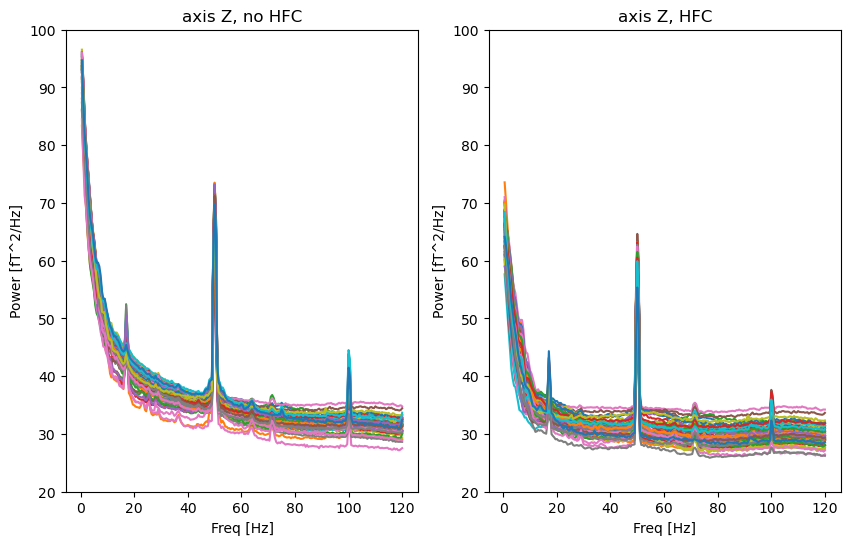

In [19]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(freqsZ,psd_dbZ.T);plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power [fT^2/Hz]');plt.title('axis Z, no HFC');

plt.subplot(1,2,2)
plt.plot(freqsZc,psd_dbZc.T);plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power [fT^2/Hz]');plt.title('axis Z, HFC');


The power over a wide frequency range is reduced following HFC. This becomes more evident when considering the spectra averaged over sensors:

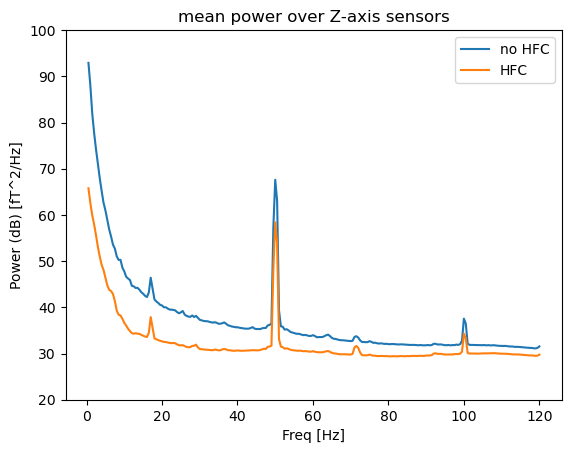

In [20]:
plt.plot(freqsZ,np.mean(psd_dbZ.T,axis=1),label='no HFC')
plt.plot(freqsZc,np.mean(psd_dbZc.T,axis=1), label='HFC')
plt.legend();plt.ylim(20, 100);plt.xlabel('Freq [Hz]');plt.ylabel('Power (dB) [fT^2/Hz]');plt.title('mean power over Z-axis sensors');

The reduction in power after HFC is now evident, particularly for the slower frequencies. The reduction is explained by artefacts being attenuated; most likely artefacts move head movements. 

#### Store the filtered data within the derivatives folder of the BIDS directory.

In [21]:
rawHFC.save(deriv_file_1, overwrite=True) 

Writing /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif
Closing /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif
[done]


[PosixPath('/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif')]

## Preregistration and Publication

Will update

## References

[1] Bezsudnova, Y., Quinn, A., & Jensen, O. (in press). *Optimizing magnetometers arrays and analysis pipelines for multivariate pattern analysis*. Journal of Neuroscience Methods.

[2] Hu, Y., Yin, C., Zhang, J., & Wang, Y. (2018). Partial least square aided beamforming algorithm in magnetoencephalography source imaging. *Frontiers in Neuroscience, 12*, 616. https://doi.org/10.3389/fnins.2018.00616

